# Introduction to Computer Music
## Ziyu Wang


This notebook discuss how to use the chord-texture disentanglement model to building a chord-texture interface, which is closely related to final project idea 4. 

The code is in general messy, however, I try to make this notebook clean though. For details about the method, please have a look at https://program.ismir2020.net/poster_5-05.html. For questions regarding code implementation, please contact the authors.

In [1]:
import dataset as dtst
import torch
import os
import numpy as np
import matplotlib.pyplot as plt

C:\Users\Willi\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.2' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


### 1 Data representation

We will use primarily 4 types of mdata representation for polyphonic music and chord progressions.

In [2]:
sample1 = np.load('./sample1.npz')
sample2 = np.load('./sample2.npz')
print(list(sample1.keys()), list(sample2.keys()))

['pr', 'pr_mat', 'ptree', 'c'] ['pr', 'pr_mat', 'ptree', 'c']


In [3]:
def load_sample(sample):
    pr = sample['pr']
    pr_mat = sample['pr_mat']
    ptree = sample['ptree']
    c = sample['c']
    return pr, pr_mat, ptree, c

In [4]:
pr1, pr_mat1, ptree1, c1 = load_sample(sample1)
pr2, pr_mat2, ptree2, c2 = load_sample(sample2)

* `pr`: piano-roll matrix of size `(32, 128, 3)`, where 32 is number of timesteps (lasts 2 measures), 128 is the number of MIDI pitches, and 3 for states: 0 is onset, 1 is sustain, 2 is rest.

(32, 128, 3) (32, 128, 3)


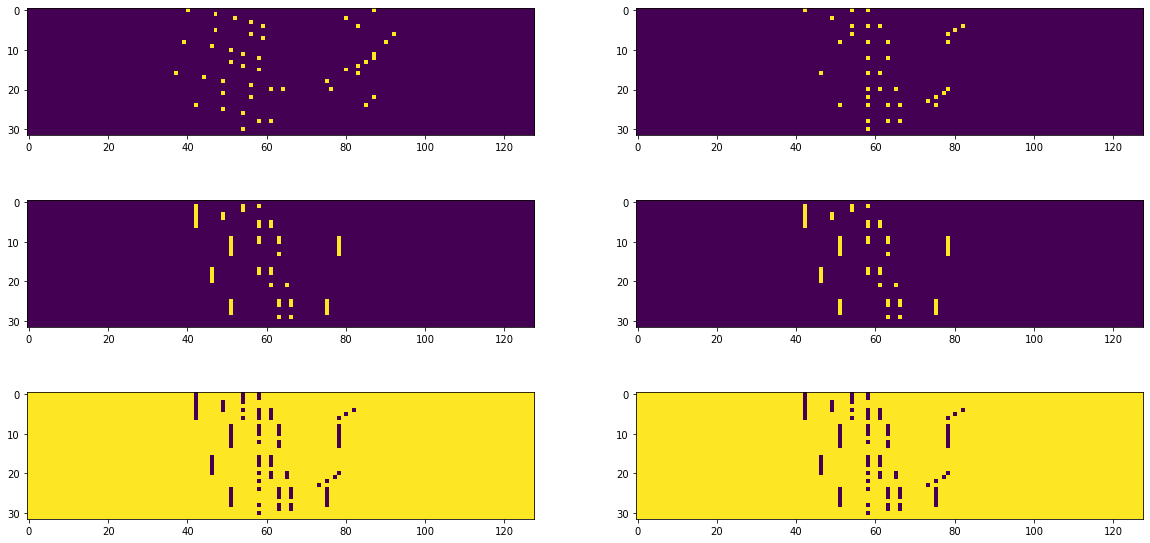

In [5]:
# pr: (32, 128, 3)
print(pr1.shape, pr2.shape)
fig = plt.figure(figsize=(20, 10))
ax = plt.subplot(321)
ax.imshow(pr1[:, :, 0])
ax = plt.subplot(322)
ax.imshow(pr2[:, :, 0])
ax = plt.subplot(323)
ax.imshow(pr2[:, :, 1])
ax = plt.subplot(324)
ax.imshow(pr2[:, :, 1])
ax = plt.subplot(325)
ax.imshow(pr2[:, :, 2])
ax = plt.subplot(326)
ax.imshow(pr2[:, :, 2])
plt.show()

* `pr_mat1`: a viariation of piano-roll representation of size `(32, 128)`, where 32 is number of timesteps, and 128 is the number MIDI pitches. The $(t, p)$-position records the duration of the note starting at time $t$ of pitch $p$.

(32, 128) (32, 128)


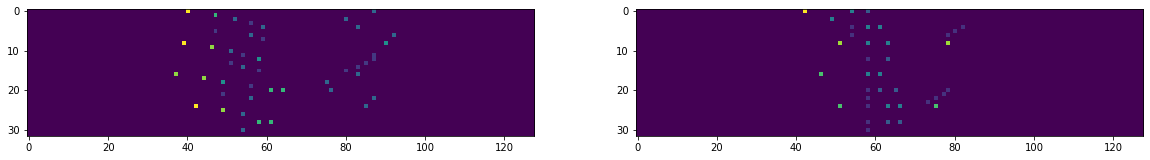

In [6]:
print(pr_mat1.shape, pr_mat2.shape)
fig = plt.figure(figsize=(20, 10))
ax = plt.subplot(121)
ax.imshow(pr_mat1)
ax = plt.subplot(122)
ax.imshow(pr_mat2)
plt.show()

* `ptree`: for PianoTree, is a tree-like data structure for polyphonic music invented by myself. It is stored in matrix format of size `(32, 16, 6)`, and sometimes `(32, 15, 6)`. The firt axis is for 32 timesteps; the second axis for notes sharing the same onsets; and the third axis for pitch (128 MIDI pitches) and 5 binary digits to represent note duration. A more detailed explantation of PianoTree data structure is explained in the paper: https://program.ismir2020.net/poster_3-06.html

(32, 16, 6) (32, 16, 6)


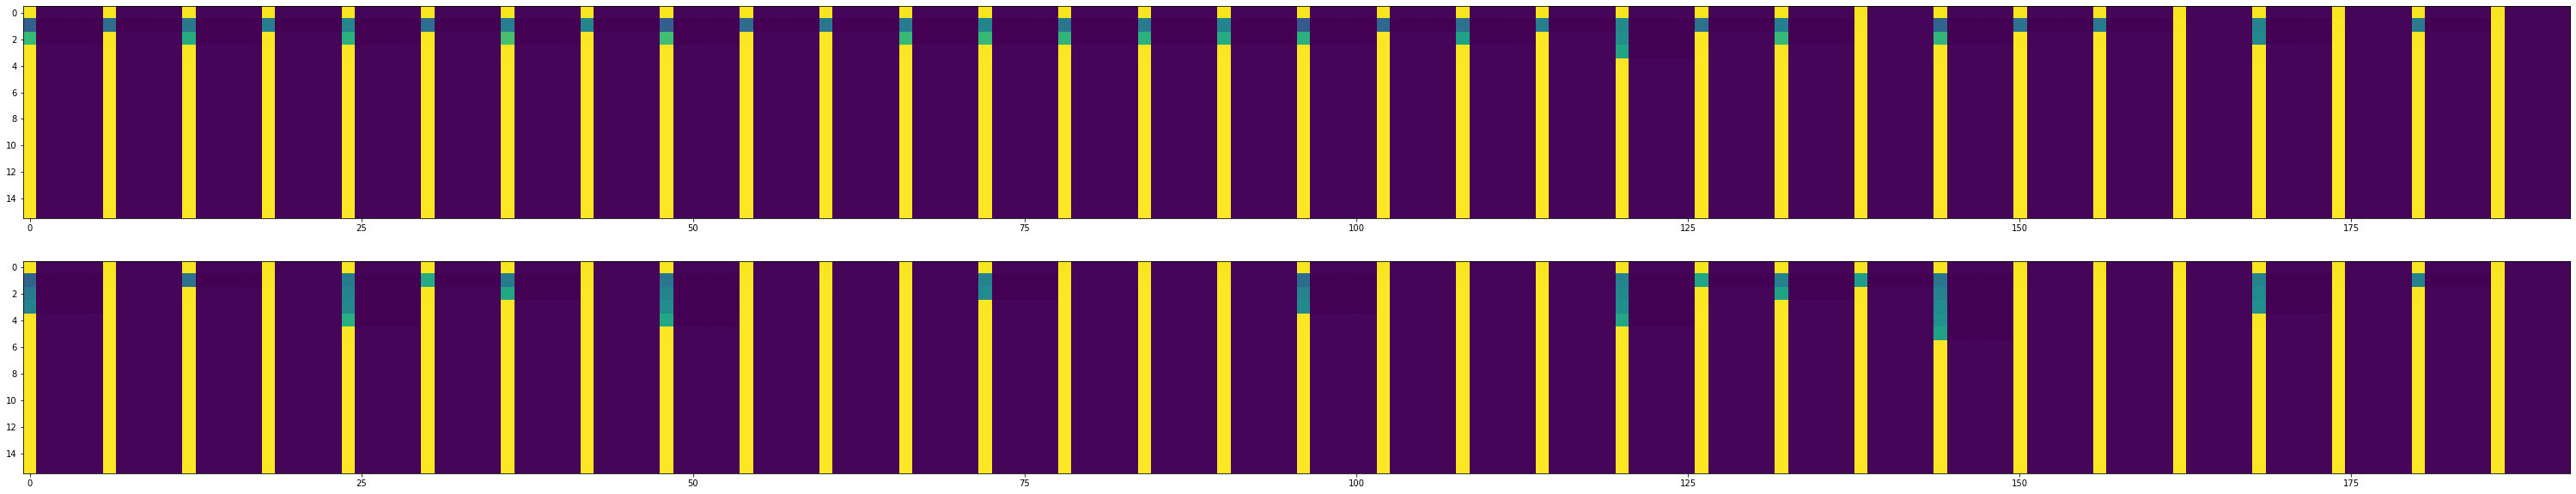

In [7]:
print(ptree1.shape, ptree2.shape)
fig = plt.figure(figsize=(80, 10))
ax = plt.subplot(211)
ax.imshow(ptree1.transpose(1, 0, 2).reshape((16, 32 * 6)))
ax = plt.subplot(212)
ax.imshow(ptree2.transpose(1, 0, 2).reshape((16, 32 * 6)))
plt.show()

In [8]:
print(ptree1[0])
print(ptree2[4])

[[128   2   2   2   2   2]
 [ 40   0   0   1   0   1]
 [ 87   0   0   0   0   1]
 [129   2   2   2   2   2]
 [130   2   2   2   2   2]
 [130   2   2   2   2   2]
 [130   2   2   2   2   2]
 [130   2   2   2   2   2]
 [130   2   2   2   2   2]
 [130   2   2   2   2   2]
 [130   2   2   2   2   2]
 [130   2   2   2   2   2]
 [130   2   2   2   2   2]
 [130   2   2   2   2   2]
 [130   2   2   2   2   2]
 [130   2   2   2   2   2]]
[[128   2   2   2   2   2]
 [ 54   0   0   0   0   0]
 [ 58   0   0   0   1   0]
 [ 61   0   0   0   1   0]
 [ 82   0   0   0   0   0]
 [129   2   2   2   2   2]
 [130   2   2   2   2   2]
 [130   2   2   2   2   2]
 [130   2   2   2   2   2]
 [130   2   2   2   2   2]
 [130   2   2   2   2   2]
 [130   2   2   2   2   2]
 [130   2   2   2   2   2]
 [130   2   2   2   2   2]
 [130   2   2   2   2   2]
 [130   2   2   2   2   2]]


* `c`: chord label of size (8, 36), where the first axis is for 8 beats (lasts 2 measures), and the second axis adopts a 36-dim representation of chord: 0 - 12: the root pitch class; 12 - 24: the chroma; and 24 - 36: the bass.

(8, 36) (8, 36)


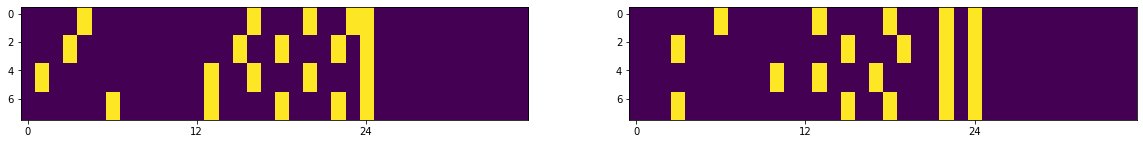

In [9]:
print(c1.shape, c2.shape)
fig = plt.figure(figsize=(20, 10))
ax = plt.subplot(121)
ax.imshow(c1)
ax.set_xticks(np.arange(0, 36, 12))
ax = plt.subplot(122)
ax.imshow(c2)
ax.set_xticks(np.arange(0, 36, 12))
plt.show()

In [10]:
def chd_to_str(c_mat):
    out = []
    pitches = ['C','C#','D','D#','E','F','F#','G','G#','A','A#','B']
    for c in c_mat:
        root = np.argmax(c[:12])
        root_s = pitches[root]
        chroma = np.array([i for i in range(12)])[c[12:24]==1]
        chroma = (chroma - root) % 12
        bass = np.argmax(c[24:])
        if len(chroma) == 3:
            if 7 in chroma:
                if 4 in chroma:
                    c_type = ''
                if 3 in chroma:
                    c_type = 'm'
                if 1 in chroma or 2 in chroma:
                    c_type = 'sus2'
                if 5 in chroma or 6 in chroma:
                    c_type = 'sus4'
            else:
                c_type = '6'
        if bass == 0:
            bass_s = ''
        else:
            bass_s = '/' + pitches[(root + bass) % 12]
        out.append('{}{}{}'.format(root_s, c_type, bass_s))
    for i,c in enumerate(out):
        if c == out[i-1] and i > 0:
            out[i] = ''
    return out
        
#chd_to_str(c1)

In [11]:
def simpleChd_to_chd(simple):
    out = np.zeros((len(simple), 36))
    for i, c in enumerate(simple):
        if c == []:
            out[i] = out[i-1]
        else:
            root = np.array(c[0])
            chroma = np.array(c[1])
            bass = np.array(c[2])
            out[i][root] = 1
            out[i][chroma + 12] = 1
            out[i][bass + 24] = 1
    return out

M1 = [0,[0,4,7],0]
M5 = [7,[7,11,2],0]
M4 = [5,[5,9,0],0]
m6 = [9,[9,0,4],0]

simple = [M4,M5,m6]
print(simple)
chd = simpleChd_to_chd(simple)
chd_to_str(chd)

[[5, [5, 9, 0], 0], [7, [7, 11, 2], 0], [9, [9, 0, 4], 0]]


['F', 'G', 'Am']

### Calling Style Transfer Model

In [12]:
# step 1: load the model

# load model (structure)
from model import DisentangleVAE
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = DisentangleVAE.init_model(device)

# load model parameters
# pytorch uses .pt file to save model parameters.
model_path = 'result/models/disvae-nozoth_epoch.pt'  
# setting cuda if cuda is available, which will speed up the computation.
model.load_model(model_path, map_location=device)

In [13]:
# step 2: convert numpy array to torch.Tensor
pr1 = torch.from_numpy(pr1)
print("1: ", type(pr1), pr1.size(), pr1.dtype)
pr1 = pr1.float()
print("2: ", type(pr1), pr1.size(), pr1.dtype)
pr1 = pr1.unsqueeze(0)
print("3: ", type(pr1), pr1.size(), pr1.dtype)

# combine the three operations together for the rest of inputs
pr_mat1 = torch.from_numpy(pr_mat1).float().unsqueeze(0)
ptree1 = torch.from_numpy(ptree1).float().unsqueeze(0)
c1 = torch.from_numpy(c1).float().unsqueeze(0)

pr2 = torch.from_numpy(pr2).float().unsqueeze(0)
pr_mat2 = torch.from_numpy(pr_mat2).float().unsqueeze(0)
ptree2 = torch.from_numpy(ptree2).float().unsqueeze(0)
c2 = torch.from_numpy(c2).float().unsqueeze(0)

1:  <class 'torch.Tensor'> torch.Size([32, 128, 3]) torch.int64
2:  <class 'torch.Tensor'> torch.Size([32, 128, 3]) torch.float32
3:  <class 'torch.Tensor'> torch.Size([1, 32, 128, 3]) torch.float32


In [14]:
pr_mat1 = pr_mat1.to(device)
pr_mat2 = pr_mat2.to(device)
c1 = c1.to(device)
c2 = c2.to(device)

In [15]:
# step 3: pass data to the model
# the input of the model are: c's and pr_mat's.
# the output of the model are ptree (PianoTree of size (bs, 32, 15, 6))
# In pytorch models, usually the first dimension is batch size, even if the batch size now = 1.
# If you are running multiple samples, do use batch! Batch size = 1 is not efficient in general.
print(pr_mat1.size(),c2.size())
ptree12 = model.swap(pr_mat1, pr_mat2, c1, c2, fix_rhy=True, fix_chd=False)
ptree21 = model.swap(pr_mat1, pr_mat2, c1, c2, fix_rhy=False, fix_chd=True)
print(type(ptree12), ptree12.shape)
print(type(ptree21), ptree21.shape)

torch.Size([1, 32, 128]) torch.Size([1, 8, 36])
<class 'numpy.ndarray'> (1, 32, 15, 6)
<class 'numpy.ndarray'> (1, 32, 15, 6)


In [16]:
# step 4: convert output and input to notes
ptree12 = ptree12.squeeze(0)
ptree21 = ptree21.squeeze(0)
pr12, notes12 = model.decoder.grid_to_pr_and_notes(ptree12)
pr21, notes21 = model.decoder.grid_to_pr_and_notes(ptree21)
print(notes12[0: 10], notes21[0: 10])

[Note(start=0.000000, end=1.500000, pitch=42, velocity=100), Note(start=0.000000, end=0.250000, pitch=87, velocity=100), Note(start=0.250000, end=1.500000, pitch=49, velocity=100), Note(start=0.500000, end=1.000000, pitch=54, velocity=100), Note(start=0.500000, end=1.000000, pitch=82, velocity=100), Note(start=0.750000, end=1.000000, pitch=58, velocity=100), Note(start=1.000000, end=1.500000, pitch=58, velocity=100), Note(start=1.000000, end=1.500000, pitch=85, velocity=100), Note(start=1.250000, end=1.500000, pitch=49, velocity=100), Note(start=1.500000, end=2.000000, pitch=54, velocity=100)] [Note(start=0.000000, end=1.750000, pitch=40, velocity=100), Note(start=0.000000, end=0.750000, pitch=52, velocity=100), Note(start=0.000000, end=0.500000, pitch=59, velocity=100), Note(start=0.500000, end=1.250000, pitch=47, velocity=100), Note(start=1.000000, end=1.750000, pitch=56, velocity=100), Note(start=1.000000, end=1.500000, pitch=59, velocity=100), Note(start=1.000000, end=1.500000, pit

In [17]:
_, notes11 = model.decoder.grid_to_pr_and_notes(ptree1.squeeze(0).numpy().astype(int))
_, notes22 = model.decoder.grid_to_pr_and_notes(ptree2.squeeze(0).numpy().astype(int))

In [18]:
# step 5: write to MIDI file
import pretty_midi
midi = pretty_midi.PrettyMIDI()
ins1 = pretty_midi.Instrument(0)
ins1.notes = notes11
ins2 = pretty_midi.Instrument(0)
ins2.notes = notes22
ins3 = pretty_midi.Instrument(0)
ins3.notes = notes12
ins4 = pretty_midi.Instrument(0)
ins4.notes = notes21
midi.instruments = [ins1, ins2, ins3, ins4]
midi.write('test_pre.mid')

### 3 POP909 dataset

We recommend using the POP909 dataset for the final project. The POP909 dataset contains 909 chinese pop songs with piano arrangement in MIDI format. For details about the dataset, please have a look at https://program.ismir2020.net/poster_1-04.html.

I have already preprocessed the data for research purpose. I share my code here and briefly introduce how to use it. Hope they are useful for your project.

* Raw dataset: MIDI file with beat, chord and key annotations. Please visit https://github.com/music-x-lab/POP909-Dataset.
* Quantized POP909 piano-roll series: quantized note matrices (np array) with chord and beat table. They are in the `./data` folder of this project. Look at `README.md` for detail.
* A dataset object to read POP909 piano-roll series: see below

In [ ]:
shift_low = -6
shift_high = 6
num_bar = 2
contain_chord = True
fns = dtst.collect_data_fns()
dataset = dtst.wrap_dataset(fns, np.arange(len(fns)), shift_low, shift_high,
                            num_bar=num_bar, contain_chord=contain_chord)
type(dataset)

In [ ]:
# get a two bar segment, for example,
# the dataloader makes sure that all indices will return consecutive measures.
melody, pr, pr_mat, ptree, chord = dataset[10]
print(melody.shape, pr.shape, pr_mat.shape, ptree.shape, chord.shape)

In [ ]:
len(dataset)

In [ ]:
test = np.load('./001.npz')
list(test.keys())
test["piano"][:50]